In [61]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from itertools import combinations
from pprint import pprint
import math

In [62]:
data_dir = Path('../data')

In [63]:
data_path = data_dir / 'Dataset3.csv'
df = pd.read_csv(data_path)
df

,Temperature,Humidity,Rainfall,Soil,Crop,Fertilizer
0,24.87,82.84,295.61,Clayey,rice,DAP
1,28.69,96.65,178.96,laterite,Coconut,Good NPK
2,20.27,81.64,270.44,silty clay,rice,MOP
3,25.07,95.02,192.90,sandy,Coconut,Urea
4,25.04,95.90,174.80,coastal,Coconut,Urea
...,...,...,...,...,...,...
290,26.07,96.70,143.53,sandy,Coconut,MOP
291,25.63,83.53,209.90,silty clay,rice,MOP
292,24.52,83.54,230.45,Clayey,rice,MOP
293,25.66,83.47,217.38,Clayey,rice,MOP


# discretize the data

In [64]:
df

,Temperature,Humidity,Rainfall,Soil,Crop,Fertilizer
0,24.87,82.84,295.61,Clayey,rice,DAP
1,28.69,96.65,178.96,laterite,Coconut,Good NPK
2,20.27,81.64,270.44,silty clay,rice,MOP
3,25.07,95.02,192.90,sandy,Coconut,Urea
4,25.04,95.90,174.80,coastal,Coconut,Urea
...,...,...,...,...,...,...
290,26.07,96.70,143.53,sandy,Coconut,MOP
291,25.63,83.53,209.90,silty clay,rice,MOP
292,24.52,83.54,230.45,Clayey,rice,MOP
293,25.66,83.47,217.38,Clayey,rice,MOP


In [65]:
df.describe()

,Temperature,Humidity,Rainfall
count,295.000000,295.000000,295.000000
mean,25.522068,88.472271,205.330983
std,2.495289,6.550542,43.276280
min,20.050000,80.120000,131.090000
25%,23.810000,82.275000,172.480000
50%,25.760000,84.970000,202.940000
75%,27.170000,94.800000,231.560000
max,29.870000,99.980000,298.560000


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  295 non-null    float64
 1   Humidity     295 non-null    float64
 2   Rainfall     295 non-null    float64
 3   Soil         295 non-null    object 
 4   Crop         295 non-null    object 
 5   Fertilizer   295 non-null    object 
dtypes: float64(3), object(3)
memory usage: 14.0+ KB


In [67]:
# check if there is duplicated rows or missing values
df.duplicated().sum()

0

In [68]:
df.isna().sum()

Temperature    0
Humidity       0
Rainfall       0
Soil           0
Crop           0
Fertilizer     0
dtype: int64

In [69]:
for col in df.select_dtypes('object').columns:
    print(col, df[col].unique())

Soil ['Clayey' 'laterite' 'silty clay' 'sandy' 'coastal' 'clay loam' 'alluvial']
Crop ['rice' 'Coconut']
Fertilizer ['DAP' 'Good NPK' 'MOP' 'Urea']


we choose soil as out items because it has the unique values

In [70]:
discretize_column = 'Temperature'

In [71]:
def discretize_equal_width(input_df, column, *, n_bins=0):
    input_df = input_df.copy()
    sorted_data = input_df[column].sort_values()
    if n_bins == 0:
        n_bins =  int(1 + (10 / 3) * math.log10(len(sorted_data)))
    ranges = np.linspace(sorted_data.min(), sorted_data.max(), n_bins + 1)
    labels = [str(i) for i in range(1, n_bins + 1)]
    current_bin = 0
    class_column = []
    for i, row_temp in enumerate(sorted_data):
        if row_temp > ranges[current_bin + 1]:
            current_bin += 1
        class_column.append(labels[current_bin])
    input_df['class'] = class_column
    input_df.drop(columns=[column], inplace=True)
    return input_df


In [72]:
df_width = discretize_equal_width(df, discretize_column)

In [73]:
def plot_classes(input_df):
    sns.countplot(x='class', data=input_df)
    plt.xlabel('classes')
    plt.ylabel('Count')
    plt.title('class distribution')
    plt.show()

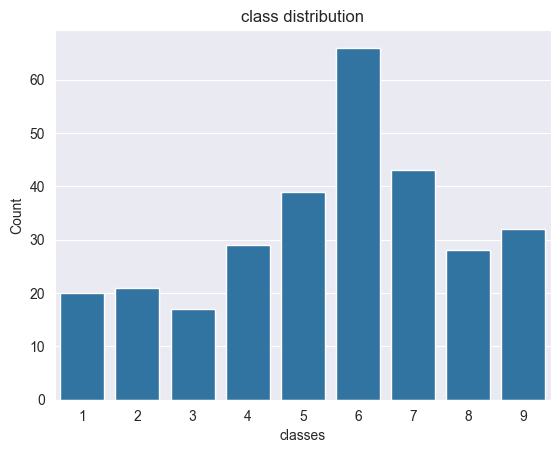

In [74]:
plot_classes(df_width)

In [75]:
def discretize_equal_freq(input_df, column, *, n_bins=0):
    input_df = input_df.copy()

    if n_bins == 0:
        n_bins = int(1 + (10 / 3) * math.log10(len(input_df[column])))

    sorted_values = sorted(input_df[column])

    bin_edges = [sorted_values[i * len(sorted_values) // n_bins] for i in range(n_bins)]
    bin_edges.append(sorted_values[-1])  # Include the maximum value
    print(bin_edges)
    labels = [str(i) for i in range(1, n_bins + 1)]

    discrete_column = []
    current_bin = 0

    for i, value in enumerate(sorted_values):
        if value > bin_edges[current_bin + 1]:
            current_bin += 1
        discrete_column.append(labels[current_bin])

    input_df['class'] = discrete_column

    return input_df

In [76]:
df_freq = discretize_equal_freq(df, discretize_column)

[20.05, 21.84, 23.45, 24.87, 25.55, 26.11, 26.76, 27.56, 28.74, 29.87]


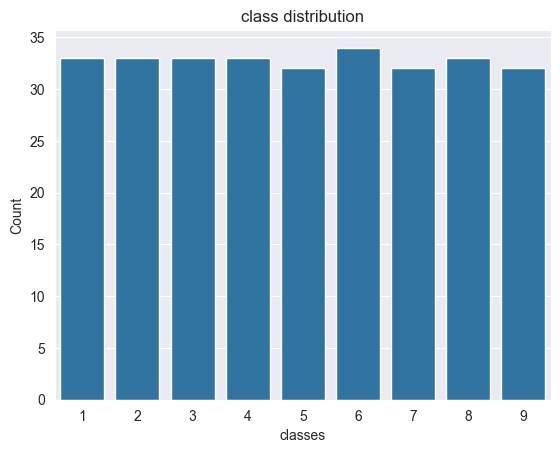

In [77]:
plot_classes(df_freq)

# Apriori and association rules

In [78]:
grouped_df = df_width.groupby(['Soil', 'Fertilizer']).agg({
    # 'Crop': set,
    # 'Fertilizer': set,
    'class': set,
}).rename(columns={'class': 'Items'})
grouped_df.to_csv(data_dir / 'part3_grouped_df.csv')
grouped_df


Items
Soil       Fertilizer                          
Clayey     DAP               {2, 3, 8, 1, 6, 5}
           Good NPK                         {6}
           MOP                  {4, 9, 2, 3, 7}
           Urea              {4, 3, 7, 1, 6, 5}
alluvial   DAP                           {7, 1}
           MOP                     {8, 7, 9, 2}
           Urea                 {4, 2, 3, 1, 5}
clay loam  DAP                     {7, 1, 2, 5}
           Good NPK                   {4, 5, 3}
           MOP                        {9, 7, 2}
           Urea                 {4, 2, 3, 1, 5}
coastal    DAP                  {4, 3, 8, 7, 6}
           Good NPK                {4, 2, 6, 5}
           MOP                  {9, 8, 7, 6, 5}
           Urea              {4, 2, 3, 1, 6, 5}
laterite   DAP                     {4, 7, 1, 2}
           Good NPK                   {5, 1, 3}
           MOP                        {8, 7, 9}
           Urea                 {4, 2, 3, 1, 5}
sandy      DAP                  {3, 8, 7, 6, 5}
           Good NPK          {4, 2, 3, 1, 6, 5}
           MOP                  {9, 8, 7, 6, 5}
           Urea              {4, 2, 3, 1, 6, 5}
silty clay DAP         {4, 2, 3, 8, 7, 1, 6, 5}
           Good NPK                         {5}
           MOP                     {4, 9, 7, 1}
           Urea           {4, 2, 3, 7, 1, 6, 5}

In [79]:
class Apriori:
    def __init__(self, min_support, min_confidence):
        self.df = None
        self.min_support = min_support
        self.min_confidence = min_confidence
        self.frequent_itemsets = []

    def set_params(self, *, min_support, min_confidence):
        self.min_support = min_support if min_support else self.min_support
        self.min_confidence = min_confidence if min_confidence else self.min_confidence

    def fit(self, input_df):
        self.df = input_df
        self._get_frequent_itemsets()
        self._get_rules()

    def _get_frequent_itemsets(self):
        self._get_frequent_1_itemsets()
        k = 2
        while True:
            frequent_itemsets = self._get_frequent_k_itemsets(k)
            if not frequent_itemsets:
                break
            self.frequent_itemsets.append(frequent_itemsets)
            k += 1

    def _get_frequent_1_itemsets(self):
        self.item_counts = Counter()
        for itemset in self.df['Items']:
            self.item_counts.update(itemset)

        n = len(self.df)
        self.frequent_itemsets.append([
            (frozenset([item]), support / n)
            for item, support in self.item_counts.items()
            if support / n >= self.min_support
        ])

    def _get_frequent_k_itemsets(self, k):
        itemsets = self.frequent_itemsets[k - 2]
        n = len(self.df)
        frequent_itemsets = []
        for itemset1, support1 in itemsets:
            for itemset2, support2 in itemsets:
                if itemset1 == itemset2:
                    continue
                union = itemset1 | itemset2
                if len(union) != k:
                    continue
                if union in (itemset for itemset, _ in frequent_itemsets):
                    continue
                support = sum(1 for itemset in self.df['Items'] if union.issubset(itemset)) / n
                if support >= self.min_support:
                    frequent_itemsets.append((union, support))
        return frequent_itemsets

    def _get_rules(self):
        self.rules = []
        for itemsets in self.frequent_itemsets:
            for itemset, support in itemsets:
                if len(itemset) < 2:
                    continue
                for antecedent in self._get_antecedents(itemset):
                    antecedent_support = self._get_support(antecedent)
                    if support / antecedent_support >= self.min_confidence:
                        self.rules.append((antecedent, itemset - antecedent, support / antecedent_support))
        return self.rules

    @staticmethod
    def _get_antecedents(itemset: set) -> list[tuple]:
        antecedents = []
        for i in range(1, len(itemset)):
            current_antecedents = combinations(itemset, i)
            current_antecedents = {frozenset(antecedent) for antecedent in current_antecedents}
            antecedents.extend(current_antecedents)
        return antecedents

    def _get_support(self, itemset):
        return sum(1 for itemset2 in self.df['Items'] if itemset.issubset(itemset2)) / len(self.df)


In [80]:
apriori = Apriori(min_support=0.4, min_confidence=0.8)

In [81]:
apriori.fit(grouped_df)

In [82]:
pprint(apriori.frequent_itemsets)

[[(frozenset({'2'}), 0.5555555555555556),
  (frozenset({'3'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'4'}), 0.5555555555555556),
  (frozenset({'7'}), 0.5555555555555556)],
 [(frozenset({'1', '2'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'4', '2'}), 0.4074074074074074),
  (frozenset({'1', '3'}), 0.4074074074074074),
  (frozenset({'5', '3'}), 0.48148148148148145),
  (frozenset({'4', '3'}), 0.4444444444444444),
  (frozenset({'1', '5'}), 0.4444444444444444),
  (frozenset({'4', '1'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'4', '5'}), 0.4074074074074074)],
 [(frozenset({'5', '1', '3'}), 0.4074074074074074)]]


In [83]:
pprint(apriori.rules)

[(frozenset({'3'}), frozenset({'5'}), 0.8666666666666666),
 (frozenset({'6'}), frozenset({'5'}), 0.8461538461538461),
 (frozenset({'1', '3'}), frozenset({'5'}), 1.0),
 (frozenset({'1', '5'}), frozenset({'3'}), 0.9166666666666666),
 (frozenset({'3', '5'}), frozenset({'1'}), 0.8461538461538461)]


# Apriori Tests with different support and confidence

In [84]:
apriori.set_params(min_support=0.3, min_confidence=0.4)
apriori.fit(grouped_df)

In [85]:
pprint(apriori.frequent_itemsets)

[[(frozenset({'2'}), 0.5555555555555556),
  (frozenset({'3'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'6'}), 0.48148148148148145),
  (frozenset({'5'}), 0.6666666666666666),
  (frozenset({'4'}), 0.5555555555555556),
  (frozenset({'7'}), 0.5555555555555556)],
 [(frozenset({'1', '2'}), 0.4074074074074074),
  (frozenset({'2', '5'}), 0.4074074074074074),
  (frozenset({'4', '2'}), 0.4074074074074074),
  (frozenset({'1', '3'}), 0.4074074074074074),
  (frozenset({'5', '3'}), 0.48148148148148145),
  (frozenset({'4', '3'}), 0.4444444444444444),
  (frozenset({'1', '5'}), 0.4444444444444444),
  (frozenset({'4', '1'}), 0.4074074074074074),
  (frozenset({'6', '5'}), 0.4074074074074074),
  (frozenset({'4', '5'}), 0.4074074074074074)],
 [(frozenset({'5', '1', '3'}), 0.4074074074074074)],
 [(frozenset({'2'}), 0.5555555555555556),
  (frozenset({'3'}), 0.5555555555555556),
  (frozenset({'1'}), 0.5555555555555556),
  (frozenset({'5'}), 0.6666666666666666),
  (frozense

In [86]:
pprint(apriori.rules)

[(frozenset({'1'}), frozenset({'2'}), 0.7333333333333333),
 (frozenset({'2'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'2'}), frozenset({'5'}), 0.7333333333333333),
 (frozenset({'2'}), frozenset({'4'}), 0.7333333333333333),
 (frozenset({'4'}), frozenset({'2'}), 0.7333333333333333),
 (frozenset({'1'}), frozenset({'3'}), 0.7333333333333333),
 (frozenset({'3'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'5'}), frozenset({'3'}), 0.7222222222222222),
 (frozenset({'3'}), frozenset({'5'}), 0.8666666666666666),
 (frozenset({'3'}), frozenset({'4'}), 0.7999999999999999),
 (frozenset({'4'}), frozenset({'3'}), 0.7999999999999999),
 (frozenset({'1'}), frozenset({'5'}), 0.7999999999999999),
 (frozenset({'1'}), frozenset({'4'}), 0.7333333333333333),
 (frozenset({'4'}), frozenset({'1'}), 0.7333333333333333),
 (frozenset({'6'}), frozenset({'5'}), 0.8461538461538461),
 (frozenset({'4'}), frozenset({'5'}), 0.7333333333333333),
 (frozenset({'1'}), frozenset({'3', '5'}), 0.73333333333

In [87]:
# get all rows that has items 3 and 4 and 5
grouped_df[grouped_df['Items'].apply(lambda x: '3' in x and '1' in x and '5' in x)]

Items
Soil       Fertilizer                          
Clayey     DAP               {2, 3, 8, 1, 6, 5}
           Urea              {4, 3, 7, 1, 6, 5}
alluvial   Urea                 {4, 2, 3, 1, 5}
clay loam  Urea                 {4, 2, 3, 1, 5}
coastal    Urea              {4, 2, 3, 1, 6, 5}
laterite   Good NPK                   {5, 1, 3}
           Urea                 {4, 2, 3, 1, 5}
sandy      Good NPK          {4, 2, 3, 1, 6, 5}
           Urea              {4, 2, 3, 1, 6, 5}
silty clay DAP         {4, 2, 3, 8, 7, 1, 6, 5}
           Urea           {4, 2, 3, 7, 1, 6, 5}

In [88]:
grouped_df[grouped_df['Items'].apply(lambda x: '5' in x)]

Items
Soil       Fertilizer                          
Clayey     DAP               {2, 3, 8, 1, 6, 5}
           Urea              {4, 3, 7, 1, 6, 5}
alluvial   Urea                 {4, 2, 3, 1, 5}
clay loam  DAP                     {7, 1, 2, 5}
           Good NPK                   {4, 5, 3}
           Urea                 {4, 2, 3, 1, 5}
coastal    Good NPK                {4, 2, 6, 5}
           MOP                  {9, 8, 7, 6, 5}
           Urea              {4, 2, 3, 1, 6, 5}
laterite   Good NPK                   {5, 1, 3}
           Urea                 {4, 2, 3, 1, 5}
sandy      DAP                  {3, 8, 7, 6, 5}
           Good NPK          {4, 2, 3, 1, 6, 5}
           MOP                  {9, 8, 7, 6, 5}
           Urea              {4, 2, 3, 1, 6, 5}
silty clay DAP         {4, 2, 3, 8, 7, 1, 6, 5}
           Good NPK                         {5}
           Urea           {4, 2, 3, 7, 1, 6, 5}